# Simple example for how to load and plot ice data

This script shows how to load and plot sea ice concentration from CICE output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The conda/analysis3 module from /g/data/hh5/public/modules. 

Check conda/analysis version

In [1]:
! conda env list

# conda environments:
#
                         /g/data/gv90/as2285/miniconda3
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-extremes
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-plots
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker
base                  *  /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04



Firstly, load modules:

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39121/status,
Dashboard: /proxy/39121/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44081,Workers: 4
Dashboard: /proxy/39121/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:44905,Total threads: 3
Dashboard: /proxy/36569/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:38977,


Start a database session:

In [4]:
session = cc.database.create_session()

Load sea ice area (`aice_m`) from the Repeat-Year forcing experiment. (We could, alternatively, try to load ice thickness (`hi_m`) or ice volume (`vicen_m`).) Note that we are just loading the last 10 years here.

Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [5]:
sic_args = {
    "expt": "01deg_jra55v13_ryf9091",
    "variable": "aice_m",
    "start_time": "2090-02-01",
    "end_time":"2100-01-01",
    "decode_coords":False
}

sic = cc.querying.getvar(
    session=session, 
    **sic_args
)

In [6]:
sic

<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)>
dask.array<concatenate, shape=(120, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2090-02-01 00:00:00 ... 2100-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes: (12/13)
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

**Another messy thing about CICE is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [7]:
sic['time'] = sic.time.to_pandas() - timedelta(hours = 12)

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [8]:
area_t = cc.querying.getvar(sic_args['expt'], 'area_t',session,n = 1).load()

In [9]:
area_t

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

Our CICE data is missing x&y coordinate values, so we can also get them from area_t

In [10]:
sic.coords['ni'] = area_t['xt_ocean'].values
sic.coords['nj'] = area_t['yt_ocean'].values

So that our new coordinates are recognised as cf standard, we also need to copy the attributes. This notebook is designed to use `cf-xarray`. This means the rest of the notebook is [Model Agnostic](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html).

In [11]:
sic.ni.attrs=area_t.xt_ocean.attrs
sic.nj.attrs=area_t.yt_ocean.attrs

In [12]:
sic = sic.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [13]:
sic.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Now that we have axes with cf compliant coordinates, we can select using `latitude` keywords.

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

In [14]:
sic

<xarray.DataArray 'aice_m' (time: 120, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(120, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2090-01-31 12:00:00 ... 2099-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes: (12/13)
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [15]:
area_t

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [16]:
(sic*area_t).cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates:   longitude: ['geolon_t', 'xt_ocean']
                        latitude: ['geolat_t', 'yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. 
We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [17]:
sic=sic.where(sic>=0.15)

si_area=(sic*area_t).drop({'geolon_t','geolat_t'})

In [18]:
si_area.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In [19]:
SH_area=si_area.cf.sel(latitude=slice(-90,-45)).cf.sum(['latitude','longitude'])
NH_area=si_area.cf.sel(latitude=slice(45,90)).cf.sum(['latitude','longitude'])

As we are using a repeat year forcing experiemnt, the sea ice cycle is very regular:

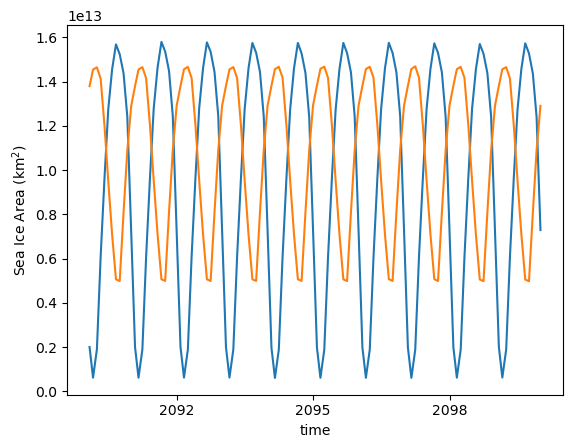

In [20]:
SH_area.plot()
NH_area.plot()
_=plt.ylabel('Sea Ice Area (km$^{2}$)')

The seasonal cycle of sea-ice concentration is more interesting

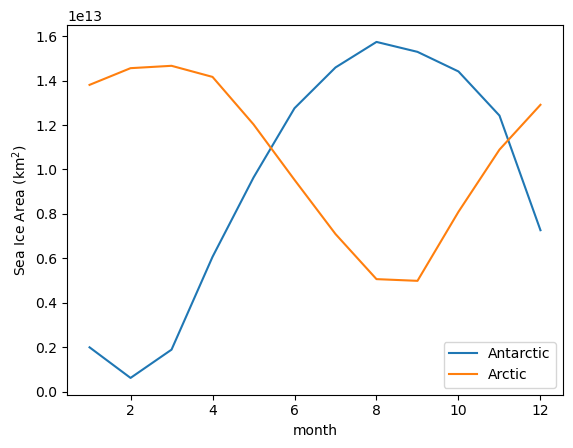

In [21]:
SH_area.groupby('time.month').mean('time').plot(label='Antarctic')
NH_area.groupby('time.month').mean('time').plot(label='Arctic')
plt.legend()
_=plt.ylabel('Sea Ice Area (km$^{2}$)')

# Making Maps

If we just plot a selected month now, you see that everything North of 65N is skewed. 

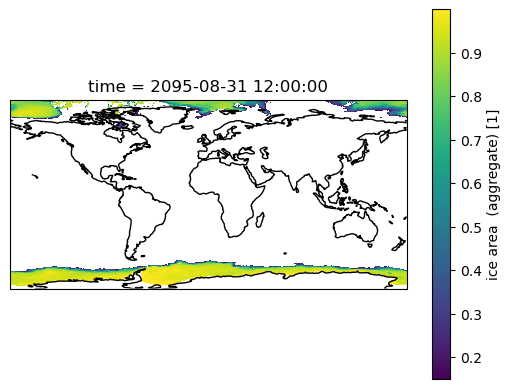

In [22]:
ax=plt.subplot(projection=ccrs.PlateCarree())
sic.sel(time='2095-08-31').plot(transform=ccrs.PlateCarree())
ax.coastlines()

Most of our work is in the Southern Ocean, so maybe we don't care. But if you are interested in the Arctic, then we need to account for the tri-polar ocean grid that ACCESS uses. The easiest way out of that is using contourf, and the passing the x and y coordinates.

See [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html) tutorial for more help with plotting!

We need the geolon and geolat fields from area_t

In [23]:
sic=sic.assign_coords({
    'geolat_t':area_t.geolat_t,
    'geolon_t':area_t.geolon_t
})

Use contourf, and the geolon and geolat fields

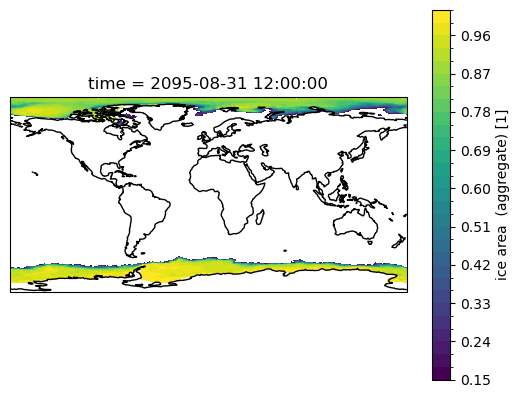

In [24]:
ax=plt.subplot(projection=ccrs.PlateCarree())
sic.sel(time='2095-08-31')[0].plot.contourf(
    transform=ccrs.PlateCarree(), x='geolon_t', y='geolat_t', levels=33)
ax.coastlines()

Using cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [25]:
#A function for plotting tri-polar data
def plot_si_conc(data):
    
    data.plot.contourf(
        transform=ccrs.PlateCarree(),
        x='geolon_t', 
        y='geolat_t', 
        levels=33 ,
        cbar_kwargs={
            'label':'Sea Ice Concentration'
        }
    )

    ax=plt.gca()
    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            # xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
        )

    ax.coastlines()


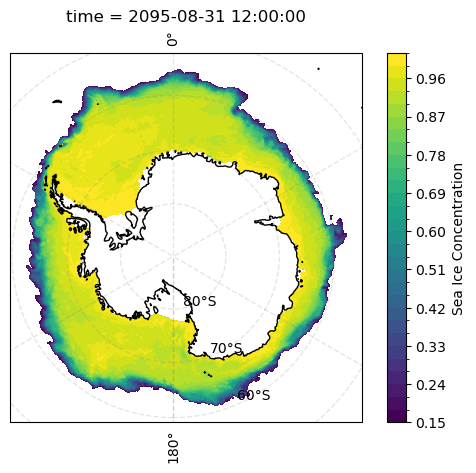

In [26]:
def plot_sh_si_conc():
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())
    plot_si_conc(
        sic.cf.sel(latitude=slice(-90,-45), time='2095-08')[0]
    )

plot_sh_si_conc()

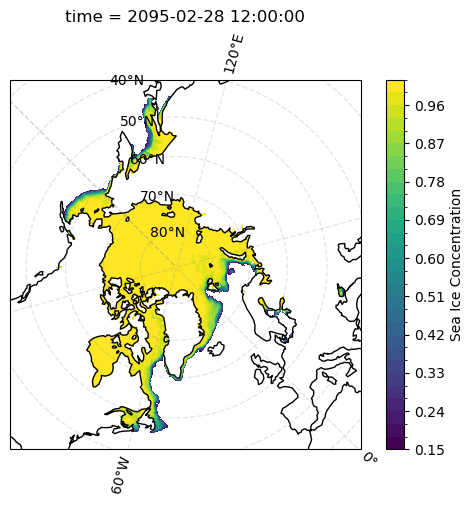

In [27]:
def plot_nh_si_conc():
    crs=ccrs.NorthPolarStereo(central_longitude=-45,true_scale_latitude=70)
    ax=plt.subplot(projection=crs)
    plot_si_conc(
        sic.cf.sel(latitude=slice(45,90), time='2095-02')[0]
    )

plot_nh_si_conc()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html].

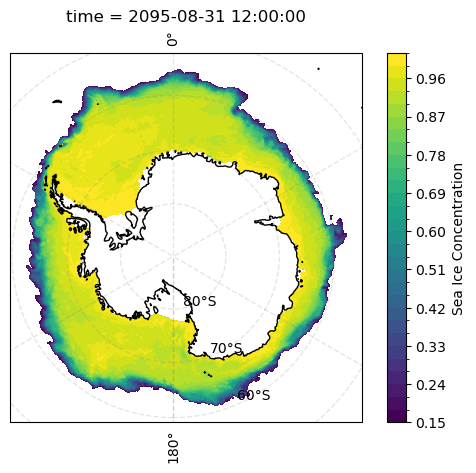

In [28]:
plot_sh_si_conc()
plt.savefig('MyFirstPlot.png', dpi = 300)